### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

In [1]:
import os
import re
import time
import warnings

import pandas as pd
import torch
from IPython.display import HTML, display
from transformers import T5ForConditionalGeneration, T5Tokenizer
from transformers.optimization import Adafactor

warnings.filterwarnings('ignore')

In [ ]:
#Load in dataset

In [2]:
train_df = pd.read_csv('dataset/e2e_training_data.csv')
print(train_df.shape)
train_df.head()

(42061, 2)


,mr,ref
0,"name[The Vaults], eatType[pub], priceRange[mor...",The Vaults pub near Café Adriatic has a 5 star...
1,"name[The Cambridge Blue], eatType[pub], food[E...","Close to Café Brazil, The Cambridge Blue pub s..."
2,"name[The Eagle], eatType[coffee shop], food[Ja...",The Eagle is a low rated coffee shop near Burg...
3,"name[The Mill], eatType[coffee shop], food[Fre...",Located near The Sorrento is a French Theme ea...
4,"name[Loch Fyne], food[French], customer rating...","For luxurious French food, the Loch Fyne is lo..."


In [3]:
def processed_string(s):
    attributes = re.findall(",\\s(.*?)\\[", ", " + s)
    values = re.findall("\\[(.*?)\\]", ", " + s)
    if len(attributes) == len(values):
        return " | ".join(
            " | ".join((key, val))
            for (key, val) in dict(zip(attributes, values)).items()
        )
    else:
        raise

In [4]:
train_df["input_text"] = train_df["mr"].apply(lambda x: processed_string(x))
train_df.rename(columns={"ref": "target_text"}, inplace=True)
train_df = train_df[["input_text", "target_text"]]
train_df = train_df.sample(frac=1)
train_df.head()

,input_text,target_text
0,name | The Vaults | eatType | pub | priceRange...,The Vaults pub near Café Adriatic has a 5 star...
1,name | The Cambridge Blue | eatType | pub | fo...,"Close to Café Brazil, The Cambridge Blue pub s..."
2,name | The Eagle | eatType | coffee shop | foo...,The Eagle is a low rated coffee shop near Burg...
3,name | The Mill | eatType | coffee shop | food...,Located near The Sorrento is a French Theme ea...
4,name | Loch Fyne | food | French | customer ra...,"For luxurious French food, the Loch Fyne is lo..."


In [6]:
batch_size = 32
num_of_batches = int(len(train_df)/batch_size)
num_of_epochs = 10

In [7]:
if torch.cuda.is_available():
    dev = torch.device("cuda:0") 
    print("Running on the GPU")
else:
    dev = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [8]:
tokenizer = T5Tokenizer.from_pretrained('t5-base')
model = T5ForConditionalGeneration.from_pretrained('t5-base', return_dict=True)
#moving the model to device(GPU/CPU)
model.to(dev)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseReluDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dr

In [9]:
optimizer = Adafactor(
    model.parameters(),
    lr=1e-3,
    eps=(1e-30, 1e-3),
    clip_threshold=1.0,
    decay_rate=-0.8,
    beta1=None,
    weight_decay=0.0,
    relative_step=False,
    scale_parameter=False,
    warmup_init=False
)

In [10]:
def progress(loss,value, max=100):
    return HTML(""" Batch loss :{loss}
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(loss=loss,value=value, max=max))

In [11]:
#Sets the module in training mode
model.train()

loss_per_10_steps=[]
for epoch in range(1,num_of_epochs+1):
    print('Running epoch: {}'.format(epoch))
    running_loss=0
    out = display(progress(1, num_of_batches+1), display_id=True)
    for i in range(num_of_batches):
        inputbatch=[]
        labelbatch=[]
        new_df=train_df[i*batch_size:i*batch_size+batch_size]
        for indx,row in new_df.iterrows():
#             input = 'WebNLG: '+row['input_text']+'</s>'
            input = row['input_text']+'</s>'
            labels = row['target_text']+'</s>'   
            inputbatch.append(input)
            labelbatch.append(labels)
        inputbatch=tokenizer.batch_encode_plus(inputbatch,padding=True,max_length=400,return_tensors='pt')["input_ids"]
        labelbatch=tokenizer.batch_encode_plus(labelbatch,padding=True,max_length=400,return_tensors="pt")["input_ids"]
        inputbatch=inputbatch.to(dev)
        labelbatch=labelbatch.to(dev)

        # clear out the gradients of all Variables 
        optimizer.zero_grad()

        # Forward propogation
        outputs = model(input_ids=inputbatch, labels=labelbatch)
        loss = outputs.loss
        loss_num=loss.item()
#         logits = outputs.logits
        running_loss+=loss_num
        if i%10 ==0:      
            loss_per_10_steps.append(loss_num)
        out.update(progress(loss_num,i, num_of_batches+1))

        # calculating the gradients
        loss.backward()

        #updating the params
        optimizer.step()
    
    running_loss=running_loss/int(num_of_batches)
    print('Epoch: {} , Running loss: {}'.format(epoch,running_loss))

Running epoch: 1


Epoch: 1 , Running loss: 0.7052038458475057
Running epoch: 2


Epoch: 2 , Running loss: 0.6091242384965017
Running epoch: 3


Epoch: 3 , Running loss: 0.5733697631678444
Running epoch: 4


Epoch: 4 , Running loss: 0.5475947325723175
Running epoch: 5


Epoch: 5 , Running loss: 0.5238249325498235


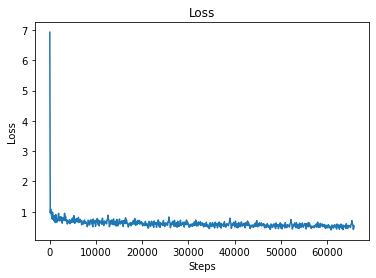

In [12]:
import matplotlib.pyplot as plt
steps = [i*100 for i in range(len(loss_per_10_steps))]
plt.plot(steps, loss_per_10_steps)
plt.title('Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

In [13]:
model.eval()
input_ids = tokenizer.encode("name | Blue Spice | eatType | coffee shop | customer rating | average | near | Burger King </s>", return_tensors="pt")  # Batch size 1
input_ids=input_ids.to(dev)
outputs = model.generate(input_ids)
tokenizer.decode(outputs[0])

'<pad> Blue Spice is a coffee shop near Burger King. It has an average customer rating and is'

In [14]:
torch.save(model.state_dict(),'model/e2e_model.bin')

In [2]:
!wget -P model https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json

--2021-09-09 04:57:03--  https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.86.174
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.86.174|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1199 (1.2K) [application/json]
Saving to: ‘model/t5-base-config.json.1’

100%[======================================>] 1,199       --.-K/s   in 0s      

2021-09-09 04:57:04 (16.0 MB/s) - ‘model/t5-base-config.json.1’ saved [1199/1199]



In [16]:
model = T5ForConditionalGeneration.from_pretrained('model/e2e_model.bin', return_dict=True,config='model/t5-base-config.json')

In [29]:
def generate(text):
    model.eval()
#     input_ids = tokenizer.encode("WebNLG:{} </s>".format(text), return_tensors="pt")  # Batch size 1
    input_ids = tokenizer.encode("{} </s>".format(text), return_tensors="pt")  # Batch size 1
    # input_ids.to(dev)
    s = time.time()
    outputs = model.generate(input_ids)
    gen_text=tokenizer.decode(outputs[0]).replace('<pad>','').replace('</s>','')
    elapsed = time.time() - s
    print('Generated in {} seconds'.format(str(elapsed)[:4]))
    return gen_text

In [34]:
generate("name | The Cricketers | eatType | coffee shop | customer rating | 1 out of 5 | familyFriendly | yes | near | Avalon")

Generated in 0.63 seconds


' The Cricketers is a coffee shop near Avalon. It is kid friendly and has'

In [35]:
generate("name | The Mill | eatType | pub | food | Fast food | priceRange | Â£20-25 | customer rating | high | area | riverside | familyFriendly | yes | near | CafÃ© Rouge")

Generated in 0.82 seconds


' The Mill is a kid friendly pub in the riverside area. It is located near the'

In [36]:
generate("name | Blue Spice | eatType | coffee shop | area | city centre")

Generated in 0.65 seconds


' Blue Spice is a coffee shop located in the city centre. It is in the city centre'

In [37]:
generate("name | Blue Spice | eatType | coffee shop | customer rating | average | near | Burger King")

Generated in 0.61 seconds


' Blue Spice is a coffee shop near Burger King. It has an average customer rating and is'